In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [2]:
sql = '''
SELECT
  pct,
  month,
  bnf_name,
  rx.bnf_code,
  SUM(items) AS total_items,
  SUM(actual_cost) AS total_cost
FROM
  hscic.normalised_prescribing_standard AS rx
JOIN (SELECT DISTINCT bnf_code 
  FROM ebmdatalab.dmd.amp
  WHERE avail_restrict = 8) AS dmd
ON
  rx.bnf_code = dmd.bnf_code
JOIN
  hscic.ccgs AS ccgs
ON
  rx.pct=ccgs.code
WHERE
  ccgs.org_type='CCG'
GROUP BY
  pct,
  month,
  bnf_code,
  bnf_name'''


df_hospital = bq.cached_read(sql, csv_path='df_hospital.csv', use_cache=True)
df_hospital['month'] = df_hospital['month'].astype('datetime64[ns]')
df_hospital.head()

,pct,month,bnf_name,bnf_code,total_items,total_cost
0,10Q,2016-03-01,Cefotaxime Sod_Inj 1g Vl,0501021D0AAABAB,1,3.35
1,02H,2016-09-01,Vancomycin HCl_Inj 500mg Vl,0501070U0AAACAC,1,110.26
2,03N,2016-04-01,Vancomycin HCl_Inj 500mg Vl,0501070U0AAACAC,1,6.72
3,99E,2015-12-01,Pantoprazole_Inj 40mg Vl,0103050R0AAACAC,1,283.29
4,99K,2015-12-01,Esomeprazole_I/V Inf 40mg Vl (Dry),0103050E0AAACAC,1,196.50


In [3]:
df_hospital.nunique()

pct              193
month            110
bnf_name         330
bnf_code         206
total_items     1284
total_cost     69175
dtype: int64

In [4]:
df_hospital["bnf_name"].unique()

array(['Cefotaxime Sod_Inj 1g Vl                ',
       'Vancomycin HCl_Inj 500mg Vl             ',
       'Pantoprazole_Inj 40mg Vl                ',
       'Esomeprazole_I/V Inf 40mg Vl (Dry)      ',
       'Promixin_Inj 1 000 000u Vl (Dry)        ',
       'Amoxicillin Sod_Inj 1g Vl               ',
       'Methotrexate_Inj 2.5mg/ml 2ml Vl        ',
       'Amikacin_Inj 250mg/ml 2ml Vl            ',
       'Co-Amoxiclav_Inj 1g/200mg Vl            ',
       'Zoledronic Acid_I/V Inf 800mcg/ml 5ml Vl',
       'Meropenem_Inj 1g Vl (Dry)               ',
       'Zoledronic Acid_I/V Inf 40mcg/ml 100ml  ',
       'Ofev_Cap 150mg                          ',
       'Enbrel_Inj 50mg/ml 1ml Pf MyClic Pen    ',
       'Botox_Inj 100u Vl                       ',
       'Daptomycin_I/V Inf 350mg Vl (Dry)       ',
       'Ceftazidime Pentahyd_Inj 2g Vl', 'Phenylbutazone_Tab 100mg',
       'Pantoprazole_Inj 40mg Vl',
       'Levobupivac HCl_Inj 2.5mg/ml 10ml Amp',
       'Amoxicillin Sod_Inj 500m

In [6]:
##groupby bnf name  to see "biggest offenders" in terms of items
df_product = df_hospital.groupby(['bnf_code', 'bnf_name']).sum().sort_values(by = 'total_items', ascending = False)
df_product

total_items  \
bnf_code        bnf_name                                                
0408010F0AAABAB Clonazepam_Tab 500mcg                         4314716   
                Clonazepam_Tab 500mcg                         2256346   
0408010F0AAACAC Clonazepam_Tab 2mg                             633539   
                Clonazepam_Tab 2mg                             332063   
0501070I0AAABAB Colistimeth Sod_Inj 1 000 000u Vl               31861   
1501041T0AAABAB Midazolam HCl_Inj 2mg/ml 5ml Amp                29693   
0501070I0AAABAB Colistimeth Sod_Inj 1,000,000u Vl               11756   
0304010G0AAAAAA Chlorphenamine Mal_Inj 10mg/ml 1ml Amp           8593   
0501021G0AAACAC Ceftriaxone Sod_Inj 1g Vl                        6853   
1501041T0AAABAB Midazolam HCl_Inj 2mg/ml 5ml Amp                 6731   
0501021G0AAADAD Ceftriaxone Sod_Inj 2g Vl                        6105   
0501040H0AAAMAM Gentamicin Sulf_Inj 40mg/ml 2ml Vl               3303   
0304010G0AAAAAA Chlorphenamine Mal_Inj 10mg/ml 1ml Amp           2908   
0501022B0AAAAAA Ertapenem Sod_I/V Inf 1g Vl (Dry)                2820   
0211000P0AAAAAA Tranexamic Acid_Inj 100mg/ml 5ml Amp             2646   
0501014S0BBABAB Tazocin_Inj 4.5g Vl                              2607   
1501042E0AAAAAA Ketorolac Trometamol_Inj 30mg/ml 1ml Amp         2334   
0801030P0AAANAN Methotrexate_Inj 25mg/ml 2ml Vl                  2128   
0501040H0AAAMAM Gentamicin Sulph_Inj 40mg/ml 2ml Vl              2049   
0211000P0AAAAAA Tranexamic Acid_Inj 100mg/ml 5ml Amp             1993   
0501022A0AAAAAA Meropenem_Inj 500mg Vl (Dry)                     1964   
1501010F0AAABAB Ketamine_Inj 50mg/ml 10ml Vl                     1936   
0501021G0AAADAD Ceftriaxone Sod_Inj 2g Vl                        1838   
0501013C0AAADAD Amoxicillin Sod_Inj 500mg Vl                     1645   
090402000BBQFA0 Nutricia_preOp Liq                               1561   
0501040H0AAAMAM Gentamicin Sulf_Inj 40mg/ml 2ml Vl               1500   
0501012G0AAAEAE Fluclox Sod_Inj 1g Vl                            1497   
0501021G0AAACAC Ceftriaxone Sod_Inj 1g Vl                        1461   
1502010V0AAAAAA Levobupivac HCl_Inj 2.5mg/ml 10ml Amp            1453   
0704050B0BCAIBN Viridal Duo_S/Pack Inj 40mcg Cart                1429   
...                                                               ...   
0701010I0BBAFAF Prostin_E2 Gel 1mg/2.5ml Pfs                        1   
0606020V0AAAGAG Zoledronic Acid_I/V Inf 50mcg/ml 100ml              1   
0503021C0AAAIAI Aciclovir_I/V Inf 25mg/ml 10ml Vl                   1   
0503021C0AAAJAJ Aciclovir_I/V Inf 25mg/ml 20ml Vl                   1   
0605010Z0BBAAAA Somavert_Inj 10mg Vl + Dil                          1   
0606020P0AAAJAJ Pamidronate Disod_I/V Inf 3mg/ml 10ml Vl            1   
0606020P0AAAIAI Pamidronate Disod_I/V Inf 3mg/ml 5ml Vl             1   
0501120L0BBAEAB Ciproxin_I/V Inf 2mg/ml 50ml Btl                    1   
0501120L0AABFBF Ciprofloxacin_I/V Inf 2mg/ml 200ml Bag              1   
0801030W0BBAAAA Fludara_Tab 10mg                                    1   
0901030Q0BBAHAH Retacrit_Inj 10,000u/1ml Pfs                        1   
0501021H0BBABAA Fortum_I/M Or I/V Inj 500mg Vl (Dry)                1   
1001030D0BBAEAD Enbrel_Inj 25mg/0.5ml Pfs                           1   
1001030D0BBAAAA Enbrel_Inj 25mg Vl + Dil                            1   
1001010Q0AAACAC Phenylbutazone_Tab 200mg                            1   
0908010AHBBAAAA Myozyme_I/V Inf 50mg Vl (Dry)                       1   
0501060E0BBABAB Dalacin C Phos_Inj 150mg/ml 4ml Amp                 1   
0901030Q0BBAKAK Retacrit_Inj 30 000u/0.75ml Pfs                     1   
0901030Q0BBAJAJ Retacrit_Inj 20,000u/0.5ml Pfs                      1   
0901030Q0BBAFAF Retacrit_Inj 6 000u/0.6ml Pfs                       1   
0801050AMBBAAAA Sutent_Cap 12.5mg                                   1   
0901030Q0BBAEAE Retacrit_Inj 5 000u/0.5ml Pfs                       1   
0901030Q0BBADAD Retacrit_Inj 4 000u/0.4ml P

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
totalcost = df_hospital.groupby(['month'])['total_cost'].sum()
totalcost.head()

month
2010-08-01   270958.14
2010-09-01   297619.94
2010-10-01   272345.47
2010-11-01   256667.18
2010-12-01   302817.26
Name: total_cost, dtype: float64

(0, 1128188.9064999989)

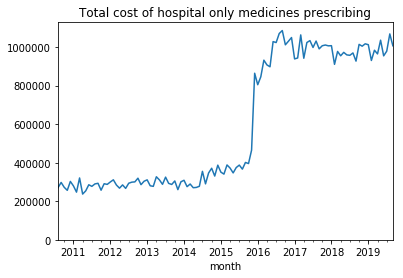

In [8]:

df_hospital.groupby("month")['total_cost'].sum().plot(kind='line', title="Total cost of hospital only medicines prescribing")
plt.ylim(0, )

In [9]:
##get list size info
sql2 = """
SELECT month, 
pct_id AS pct,
AVG(total_list_size) AS list_size
FROM ebmdatalab.hscic.practice_statistics
group by 
month, pct
order by
month, pct,
list_size
"""
df_list = bq.cached_read(sql2, csv_path='listsize.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(5)

,month,pct,list_size
0,2014-10-01,NaN,0.00
1,2014-10-01,00C,7616.00
2,2014-10-01,00D,5662.51
3,2014-10-01,00F,6102.18
4,2014-10-01,00G,8058.75


In [10]:

ccg_total_hosp = df_hospital.groupby(["month", "pct"])["total_items","total_cost"].sum().reset_index()
ccg_total_hosp.head()

,month,pct,total_items,total_cost
0,2010-08-01,00C,119,224.80
1,2010-08-01,00D,405,1419.88
2,2010-08-01,00J,232,1382.16
3,2010-08-01,00K,180,677.10
4,2010-08-01,00L,259,1594.26


In [11]:
#merge dataframes and cost / 10000

hosp_df_1000 = pd.merge(ccg_total_hosp, df_list, on=['month', 'pct'])
hosp_df_1000['cost_per_1000'] = 1000* (hosp_df_1000['total_cost']/hosp_df_1000['list_size'])
hosp_df_1000.head(5)

,month,pct,total_items,total_cost,list_size,cost_per_1000
0,2014-10-01,00C,212,1023.73,7616.00,134.42
1,2014-10-01,00D,554,1911.50,5662.51,337.57
2,2014-10-01,00J,308,1290.89,6094.54,211.81
3,2014-10-01,00K,278,1093.22,6354.13,172.05
4,2014-10-01,00L,332,2459.50,6852.09,358.94


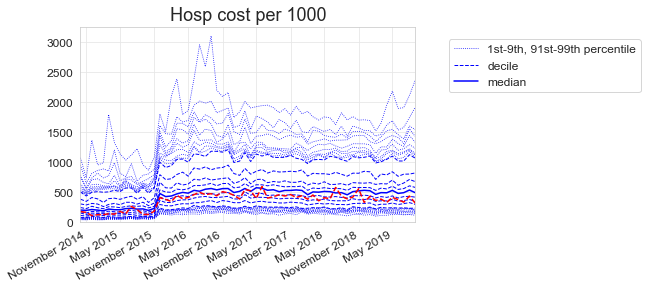

In [12]:
#create sample deciles

charts.deciles_chart(
        hosp_df_1000,
        period_column='month',
        column='cost_per_1000',
        title="Hosp cost per 1000",
        show_outer_percentiles=True)

#add in example CCG (East Berkshire)
df_subject = hosp_df_1000.loc[hosp_df_1000['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['cost_per_1000'], 'r--')

plt.show()

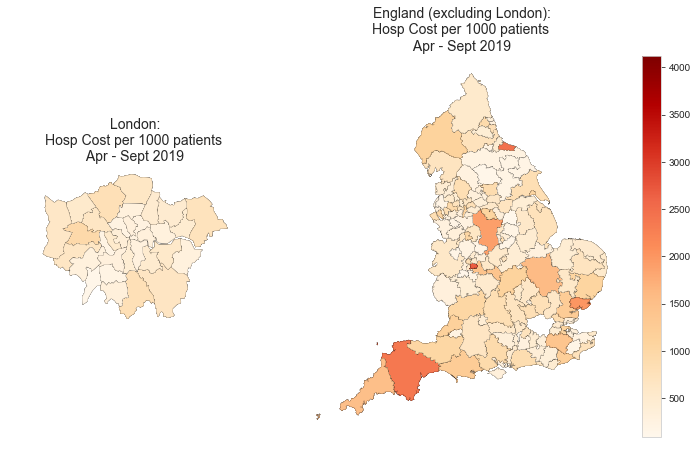

In [13]:
#create choropeth map of cost per 1000 patients
plt.figure(figsize=(12, 7))
latest_hosp_df_1000 = hosp_df_1000.loc[(hosp_df_1000['month'] >= '2019-04-01') & (hosp_df_1000['month'] <= '2019-09-01')]
plt = maps.ccg_map(latest_hosp_df_1000, title="Hosp Cost per 1000 patients \n Apr - Sept 2019 ", column='cost_per_1000', separate_london=True)
plt.show()

EHR

In [29]:
sql = """
SELECT
rx.month,
TRIM(Principal_Supplier) AS supplier,
rx.bnf_name,
rx.bnf_code,
SUM(items) AS total_items,
SUM(actual_cost) AS total_cost
FROM
 hscic.normalised_prescribing_standard AS rx
 JOIN (SELECT DISTINCT bnf_code 
  FROM ebmdatalab.dmd.amp
  WHERE avail_restrict = 8 AND bnf_code != '0408010F0AAABAB' AND
bnf_code != '0408010F0AAACAC') AS dmd
ON
  rx.bnf_code = dmd.bnf_code
JOIN
  hscic.ccgs AS ccgs
ON
  rx.pct=ccgs.code
JOIN
  alex.vendors AS software
ON
  software.ODS = rx.practice
  AND date(software.Date) = date(rx.month)
GROUP BY
rx.month,
supplier,
rx.bnf_name,
rx.bnf_code
ORDER BY
month"""



df_ehr_hosp = bq.cached_read(sql, csv_path='df_ehr_hosp.csv')
df_ehr_hosp['month'] = df_ehr_hosp['month'].astype('datetime64[ns]')
df_ehr_hosp.head(3)

,month,supplier,bnf_name,bnf_code,total_items,total_cost
0,2016-01-01,EMIS,Levobupivac HCl_Inj 2.5mg/ml 10ml Amp,1502010V0AAAAAA,11,143.87
1,2016-01-01,EMIS,Ertapenem Sod_I/V Inf 1g Vl (Dry),0501022B0AAAAAA,11,2455.63
2,2016-01-01,EMIS,Methotrexate_Inj 25mg/ml 2ml Vl,0801030P0AAANAN,5,155.56


In [30]:
##groupby bnf name  to see "biggest offenders" in terms of items
df_product_ehr = df_ehr_hosp.groupby(['bnf_code', 'bnf_name']).sum().sort_values(by = 'total_items', ascending = False)
df_product_ehr

,,total_items,total_cost
bnf_code,bnf_name,,
0501070I0AAABAB,"Colistimeth Sod_Inj 1,000,000u Vl",11055,1129713.77
1501041T0AAABAB,Midazolam HCl_Inj 2mg/ml 5ml Amp,5914,37192.25
0501070I0AAABAB,Colistimeth Sod_Inj 1 000 000u Vl,4620,474156.70
1501041T0AAABAB,Midazolam HCl_Inj 2mg/ml 5ml Amp,3262,23409.67
0304010G0AAAAAA,Chlorphenamine Mal_Inj 10mg/ml 1ml Amp,2736,241435.06
0211000P0AAAAAA,Tranexamic Acid_Inj 100mg/ml 5ml Amp,1744,40589.49
0501021G0AAADAD,Ceftriaxone Sod_Inj 2g Vl,1498,223010.10
0501040H0AAAMAM,Gentamicin Sulf_Inj 40mg/ml 2ml Vl,1419,85455.21
0501021G0AAACAC,Ceftriaxone Sod_Inj 1g Vl,1316,75251.70


Text(0.5,1,'total hosp only items per EHR vendor')

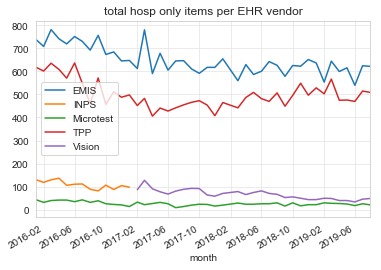

In [31]:
df_ehr_hosp.groupby(['month', 'supplier']).sum()['total_items'].unstack().plot.line()
plt.legend(loc='best')
plt.title("total hosp only items per EHR vendor")